In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sc
from scipy import io
from IPython import display
import time

from sklearn.metrics import mean_squared_error
from sklearn.cross_decomposition import PLSRegression

import warnings
from abc import ABCMeta, abstractmethod

from scipy.linalg import pinv2


from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.utils import check_array, check_consistent_length
from sklearn.utils.extmath import svd_flip
from sklearn.utils.validation import check_is_fitted, FLOAT_DTYPES
from sklearn.externals import six
from nonlinearities import *
from pls import *


np.random.seed(42)

In [4]:
NONPARAMETRICAL_TRANSROMATIONS = ['linear', 'p2', 'p3', 'p4', 's2', 's3', 's4']


def mse(Y_test, Y_pred):
    return mean_squared_error(Y_test, Y_pred)


def nmse(Y_test, Y_pred):
    return mean_squared_error(Y_test, Y_pred) / baseline(Y_test)


def baseline(Y_test):
     return mse(Y_test, np.tile(Y_test.mean(axis=0), (len(Y_test), 1)))

## Electroenergy

In [5]:
X = sc.io.loadmat('./../data/dataX.mat')['arr']
Y = sc.io.loadmat('./../data/dataY.mat')['arr']
# some daily information (5 weeks)
X = X[:-8, :-35]
Y = Y[8:, :-5]

train_size = 700

X_train, X_test = X[:train_size, :], X[train_size:, :]
Y_train, Y_test = Y[:train_size, :], Y[train_size:, :]

In [6]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((700, 168), (700, 24), (381, 168), (381, 24))

In [10]:
np.random.seed(42)
pls = PLSNonLinear(n_components=5, x_kind='pp2', y_kind='linear')
pls.fit(X_train, Y_train)
Y_pred = pls.predict(X_test)
print(nmse(Y_train, pls.predict(X_train)))
print(nmse(Y_test, Y_pred))

[-0.00953141  0.15226403]
[[ 1.]]
[ 0.1164984  -0.04562406]
[[ 0.00266428]]
[-0.02091473  0.07116551]
[[  6.34572135e-05]]
[ 0.05350901 -0.03123823]
[[ 0.00013705]]
[-0.01911977  0.03761878]
[[  2.76270951e-05]]
[ 0.02791452 -0.02154285]
[[  3.50874949e-05]]
[-0.01430633  0.02144501]
[[  1.22632492e-05]]
[ 0.01571911 -0.01432469]
[[  1.12110847e-05]]
[-0.00982256  0.01277447]
[[  5.23089410e-06]]
[ 0.00927017 -0.00928125]
[[  3.98170840e-06]]
[-0.00646288  0.00779727]
[[  2.15906700e-06]]
[ 0.00561702 -0.00592228]
[[  1.48884143e-06]]
[-0.00415817  0.00482199]
[[  8.72034839e-07]]
[[ 1.]]
[[ 0.08654947]]
[[  1.18686820e-05]]
[[  1.89383201e-09]]
[[ 1.]]
[[ 0.39969858]]
[[ 0.23221712]]
[[ 0.05354417]]
[[ 0.00752514]]
[[ 0.00096453]]
[[ 0.00012209]]
[[  1.54279849e-05]]
[[  1.94923741e-06]]
[[  2.46268449e-07]]
[[ 1.]]
[[ 0.20726077]]
[[ 0.00274901]]
[[ 0.00013443]]
[[  7.89065719e-06]]
[[  4.67758501e-07]]
[[ 1.]]
[[ 0.03349249]]
[[  5.13962098e-06]]
[[  4.16337658e-09]]
148.200867506
1

In [5]:
mse_n_comps = []

for k in np.arange(1, 25):
    pls = PLSNonLinear(n_components=k, x_kind='pp2', y_kind='linear')
    pls.fit(X_train, Y_train)
    Y_pred = pls.predict(X_test)
    mse_n_comps.append(mean_squared_error(Y_test, Y_pred))
    display.clear_output(wait=True)
    print('Iteration {} is over'.format(k))

Iteration 24 is over


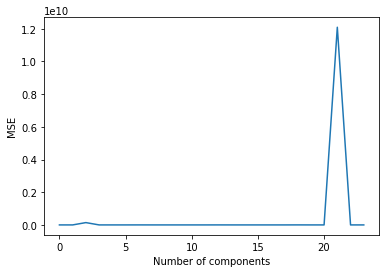

In [6]:
plt.figure(figsize=(6, 4))
plt.plot(mse_n_comps)
plt.xlabel('Number of components')
plt.ylabel('MSE')
plt.show()

In [7]:
mse_n_comps

[0.0093320266360735656,
 0.13736934327451608,
 141652348.8609902,
 0.028154169805888671,
 6.0615615991518039,
 2045.4135211907385,
 853381.03005906753,
 0.008437241175462417,
 0.014889017742023045,
 88.965197509882827,
 0.0089290237794866154,
 0.35958874128304413,
 750715.6803958962,
 0.019392775088095612,
 2063.0228857788475,
 0.033738307562711116,
 0.29262923531563784,
 3.1528251784893979,
 1683380.4988194387,
 0.01143221586170908,
 0.42685833208436952,
 12095256209.182276,
 0.0078946515051988801,
 0.85860326755403016]

In [8]:
n_comp = np.array(mse_n_comps).argmin() + 1
n_comp

23

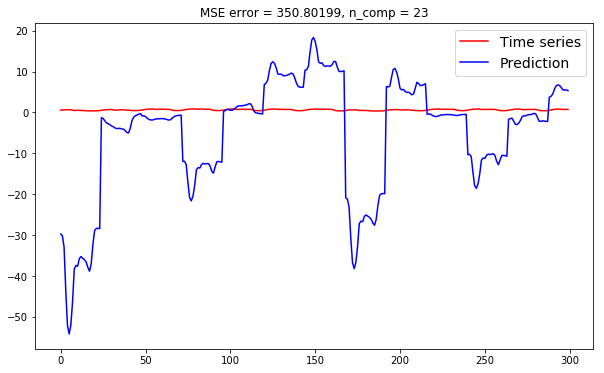

In [14]:
pls = PLSNonLinear(n_components=n_comp, x_kind='sp2', y_kind='linear')
pls.fit(X_train, Y_train)
Y_pred = pls.predict(X_test)

ts_test = Y_test.ravel()
ts_pred = Y_pred.ravel()

plt.figure(figsize=(10, 6))
plt.plot(ts_test[:300], label='Time series', c='r')
plt.plot(ts_pred[:300], label='Prediction', c='b')
plt.title('MSE error = {:.5f}, n_comp = {}'.format(mean_squared_error(Y_test, Y_pred), n_comp))
plt.legend(fontsize=14)
plt.show()

In [172]:
results_energy = {}
BASELINE_ENERGY = baseline(Y_test)

for x_transform in NONPARAMETRICAL_TRANSROMATIONS:
    for y_transform in NONPARAMETRICAL_TRANSROMATIONS:
        mse_n_comps = []
        for n_comp in range(1, 25):
            pls = PLSNonLinear(n_components=n_comp, 
                               x_kind=x_transform, 
                               y_kind=y_transform)
            pls.fit(X_train, Y_train)
            Y_pred = pls.predict(X_test)
            mse_n_comps.append(mse(Y_test, Y_pred))
        mse_n_comps = np.array(mse_n_comps)
        best_mse = mse_n_comps.min()
        results_energy[x_transform + '-' + y_transform] = mse_n_comps
        display.clear_output(wait=True)
        print('-x_transform:', x_transform)
        print('-y_transform:', y_transform)
        print('-mse: {:.5f}'.format(best_mse))
        print('-nmse: {:.5f}'.format(best_mse / BASELINE_ENERGY))

-x_transform: s4
-y_transform: s4
-mse: 0.00743


## ECoG

In [4]:
X_train_ecog = sc.io.loadmat('./../data/ECoG_X_train.mat')['X_train'].reshape([-1, 32 * 27])
Y_train_ecog = sc.io.loadmat('./../data/ECoG_Y_train.mat')['Y_train']

X_test_ecog = sc.io.loadmat('./../data/ECoG_X_test.mat')['X_hold_out'].reshape([-1, 32 * 27])
Y_test_ecog = sc.io.loadmat('./../data/ECoG_Y_test.mat')['Y_hold_out']

print(X_train_ecog.shape, Y_train_ecog.shape)
print(X_test_ecog.shape, Y_test_ecog.shape)

(12801, 864) (12801, 3)
(6087, 864) (6087, 3)


In [187]:
pls = PLSNonLinear(n_components=10)
pls.fit(X_train_ecog, Y_train_ecog)
Y_pred_ecog = pls.predict(X_test_ecog)
print(mse(Y_test_ecog, Y_pred_ecog))
print(nmse(Y_test_ecog, Y_pred_ecog))

1738.02597938
0.929019283695


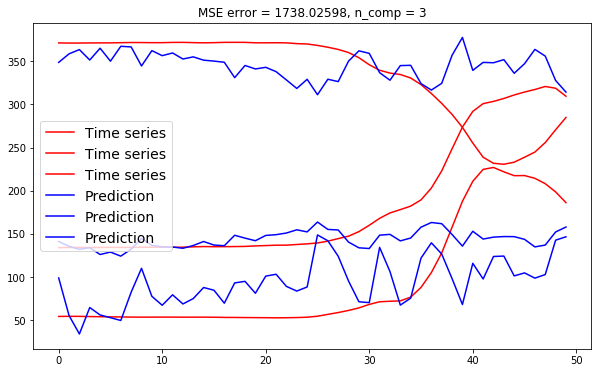

In [188]:
n_comp = 3
pls = PLSNonLinear(n_components=n_comp)
pls.fit(X_train_ecog, Y_train_ecog)
Y_pred = pls.predict(X_test_ecog)

ts_test = Y_test_ecog
ts_pred = Y_pred_ecog

plt.figure(figsize=(10, 6))
plt.plot(ts_test[50:100], label='Time series', c='r')
plt.plot(ts_pred[50:100], label='Prediction', c='b')
plt.title('MSE error = {:.5f}, n_comp = {}'.format(mse(Y_test_ecog, Y_pred_ecog), n_comp))
plt.legend(fontsize=14)
plt.show()

iteration: 24; mse: 1738.03; time: 0.11


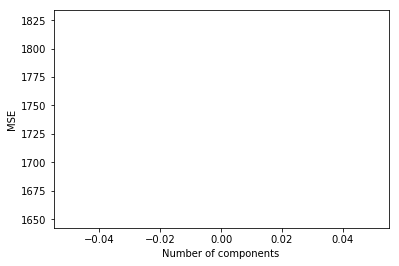

In [189]:
mse_n_comps = []

for k in np.arange(24, 25):
    start_time = time.time()
    pls = PLSNonLinear(n_components=k)
    pls.fit(X_train_ecog, Y_train_ecog)
    Y_pred = pls.predict(X_test_ecog)
    mse_n_comps.append(mse(Y_test_ecog, Y_pred_ecog))
    display.clear_output(wait=True)
    iter_time = (time.time() - start_time) / 60
    print('iteration: {}; mse: {:.2f}; time: {:.2f}'.format(k, mse_n_comps[-1], iter_time))
    
plt.figure(figsize=(6, 4))
plt.plot(mse_n_comps)
plt.xlabel('Number of components')
plt.ylabel('MSE')
plt.show()

In [190]:
n_comp = np.array(mse_n_comps).argmin() + 1
n_comp

1

In [192]:
pls = PLSNonLinear(n_components=n_comp)
pls.fit(X_train_ecog, Y_train_ecog)
Y_pred_ecog = pls.predict(X_test_ecog)

print(mse(Y_test_ecog, Y_pred_ecog), nmse(Y_test_ecog, Y_pred_ecog))

1920.39301594 1.02649912329


In [5]:
results_ecog = {}
BASELINE_ECOG = baseline(Y_test_ecog)

for x_transform in NONPARAMETRICAL_TRANSROMATIONS:
    for y_transform in ['linear']:
        mse_n_comps = []
        for n_comp in [1, 5, 10, 15, 20]:
            pls = PLSNonLinear(n_components=n_comp, 
                               x_kind=x_transform, 
                               y_kind=y_transform)
            pls.fit(X_train_ecog, Y_train_ecog)
            Y_pred_ecog = pls.predict(X_test_ecog)
            mse_n_comps.append(mse(Y_test_ecog, Y_pred_ecog))
        mse_n_comps = np.array(mse_n_comps)
        best_mse = mse_n_comps.min()
        results_ecog[x_transform + '-' + y_transform] = mse_n_comps
        display.clear_output(wait=True)
        print('-x_transform:', x_transform)
        print('-y_transform:', y_transform)
        print('-mse: {:.5f}'.format(best_mse))
        print('-nmse: {:.5f}'.format(best_mse / BASELINE_ECOG))

-x_transform: s4
-y_transform: linear
-mse: 1756.91911
-nmse: 0.93912


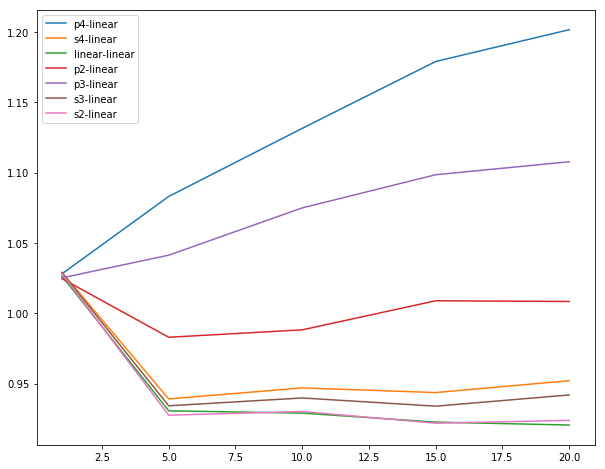

In [11]:
plt.figure(figsize=(10, 8))

for key, val in results_ecog.iteritems():
    plt.plot([1, 5, 10, 15, 20], val / BASELINE_ECOG, label=key)

plt.legend()
plt.show()

## Nonlinear transformations

In [42]:
def g1(x, a=0., b=1.):
    return np.sign(x) * np.exp(a) * (np.exp(b * np.abs(x)) - 1)


def g2(x, a=0.):
    return np.sign(x) * np.exp(a) * np.sqrt(np.abs(x))


def g3(x, a=0., b=1.):
    return np.sign(x) * np.exp(a) * (np.exp(b * np.sqrt(np.abs(x))) - 1)


def g4(x, a=0., b=1.):
    return np.sign(x) * np.exp(a) * (np.exp(b * np.abs(x) ** (1./3)) - 1)

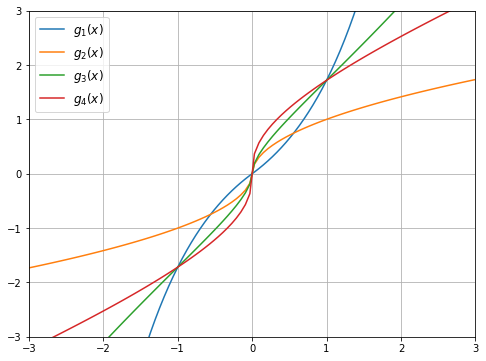

In [51]:
funcs_names = ['$g_1(x)$', '$g_2(x)$', '$g_3(x)$', '$g_4(x)$']
funcs = [g1, g2, g3, g4]
x = np.linspace(start=-3, stop=3, num=100)

plt.figure(figsize=(8, 6))
for f, name in zip(funcs, funcs_names):
    plt.plot(x, f(x), label=name)

plt.legend(fontsize=12)
plt.grid()
plt.xlim([-3., 3.])
plt.ylim([-3., 3.])
plt.show()

In [52]:
def ginv_1(y, a=0., b=1., tol=1e-9):
    return np.sign(y) * np.log(1 + np.abs(y) * np.exp(-a)) / (b + tol)


def ginv_2(y, a=0.):
    return np.sign(y) * (np.exp(-a) * y) ** 2


def ginv_3(y, a=0., b=1., tol=1e-9):
    return np.sign(y) * (np.log(1 + np.abs(y) * np.exp(-a)) / (b + tol)) ** 2


def ginv_4(y, a=0., b=1., tol=1e-9):
    return np.sign(y) * (np.log(1 + np.abs(y) * np.exp(-a)) / (b + tol)) ** 3

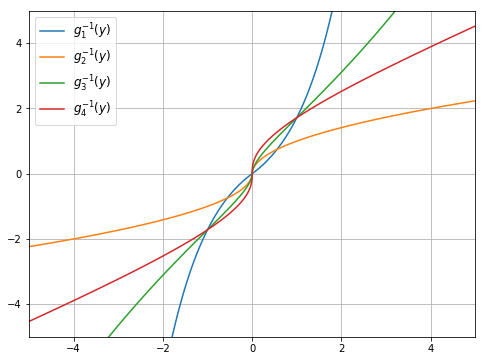

In [53]:
funcs_names = ['$g^{-1}_1(y)$', '$g^{-1}_2(y)$', '$g^{-1}_3(y)$', '$g^{-1}_4(y)$']
funcs = [ginv_1, ginv_2, ginv_3, ginv_4]
x = np.linspace(start=-5, stop=5, num=100)

plt.figure(figsize=(8, 6))
for f, name in zip(funcs, funcs_names):
    plt.plot(f(x), x, label=name)

plt.legend(fontsize=12)
plt.grid()
plt.xlim([-5., 5.])
plt.ylim([-5., 5.])
plt.show()

In [32]:
np.sqrt(np.mean((Y_test - Y_test.mean()) ** 2))

123.88404105191663

In [25]:

np.random.randn(2)

array([ 0.49671415, -0.1382643 ])